In [1]:
#加载飞桨、Numpy和相关类库
import numpy as np
import pyeeg as pe
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
import numpy as np
import pylab as pl
 
def wgn(x, snr):
    snr = 10**(snr/10.0)
    xpower = np.sum(x**2)/len(x)
    npower = xpower / snr
    return np.random.randn(len(x)) * np.sqrt(npower)
 
# t = np.arange(0, 1000) * 0.1
# x = np.sin(t)
# n = wgn(x, 5)
# xn = x+n # 增加了6dBz信噪比噪声的信号

In [3]:
#特征提取
def feature_extraction(trainData):
    
    band = [4,8,13,16,30,45] #5 bands    band = [4,8,12,16,25,45]  
    sample_rate = 128 #Sampling rate of 128 Hz

    features = trainData.reshape(trainData.shape[0], 32, 7680)

    newData=[]
    for i in range(features.shape[0]):    #样本数
        channel_features=[]
        for j in range(32):
            X = features[i][j]
            Y = pe.bin_power(X, band, sample_rate)
            channel_features += list(Y[0])
        newData.append(np.array(channel_features))

    return np.array(newData)

In [4]:
def Gaussian_normalization(trainData, testData):
    """高斯归一化"""

    #训练样本归一化
    feature=trainData[:,:-1]
    mean=feature.mean(axis=0)
    std=feature.std(axis=0)
    feature-=mean
    feature/=std
    trainData[:,:-1] = feature

    #测试样本归一化
    feature=testData[:,:-1]
    feature-=mean
    feature/=std
    testData[:,:-1] = feature

    return trainData, testData

In [5]:
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def trainModel(trainData, testData):
    
    trainLabel = trainData[:, -1]
    trainData = trainData[:, :-1]
    
    testLabel = testData[:, -1]
    testData = testData[:, :-1]
    
#     svmModel = svm.SVC()
#     svmModel.fit(data_training, valtrain) 
#     ypredict=svmModel.predict(data_testing)
#     print("SVMacc：",accuracy_score(ypredict,valtest)) 

    rfModel = RandomForestClassifier(n_estimators=512, n_jobs=5)
    rfModel.fit(trainData, trainLabel)
    ypredict = rfModel.predict(testData)
    acc = accuracy_score(ypredict,testLabel)
    print("acc = {:.2f}".format(acc))
    return acc

## 训练集、测试集的标签比例与总体样本的类标签比例相同
StratifiedShuffleSplit

In [6]:
emotionDim = 0    #0 Valence 1 Arousal

multiples = 249    #数据增强multiple倍
snr = 5    #信噪比
ratio = 0.2    #测试集占的比例
num_splits = 10    #测试10次
randomState = 2021    #随机状态
allAcc = []    #记录num_splits次的准确率

dir = 'E:\JupyterNotebookWorkSpace\dataSet\\1280x258050(32x8064+2).npy'

AllSub = np.load(dir)
feature = AllSub[: , :-2].reshape((1280, 32, 8064))

feature = feature[:, :, 384:]
feature = feature.reshape((1280, 245760))

label = np.where(AllSub[: , -2:] >= 5 , 1 , -1)
label = label[:, emotionDim]
del AllSub

sss = StratifiedShuffleSplit(n_splits=num_splits, test_size=ratio, random_state = randomState)#分成num_splits组，测试比例为ratio
num_split = 1    #第一次split
for train_index, test_index in sss.split(feature, label):
    X_train, X_test = feature[train_index], feature[test_index]#训练集对应的值
    y_train, y_test = label[train_index], label[test_index]#类别集对应的值
    
    
    unitSignal = feature_extraction(X_train)
    np.save('./trainSetFreq/{}.npy'.format(0), np.append(unitSignal, y_train.reshape((-1, 1)), axis = 1))
    
    unitSignal = feature_extraction(X_test)
    np.save('./testSetFreq.npy', np.append(unitSignal, y_test.reshape((-1, 1)), axis = 1))
    
    
    # 添加高斯白噪声，训练数据增强multiple倍
    for multiple in range(multiples):
        newSignal = []
        for signal in X_train:
            newChannelFeature = []
            channelFeature = signal.reshape((32, 7680))
            for channel in channelFeature:
                noise = wgn(channel, snr)
                noiseSignal = channel + noise
                newChannelFeature.append(noiseSignal)
            newChannelFeature = np.array(newChannelFeature).reshape(245760)
            newSignal.append(newChannelFeature)
        newSignal = np.array(newSignal)
        unitSignal = feature_extraction(newSignal)
        np.save('./trainSetFreq/{}.npy'.format(multiple + 1), np.append(unitSignal, y_train.reshape((-1, 1)), axis = 1))
          
    del X_test
    del X_train
    del unitSignal
    
    
    #加载训练集、测试集，开始训练、测试
    trainSet = []
    for multiple in range(multiples + 1):
        trainFreqFeature = np.load('./trainSetFreq/{}.npy'.format(multiple))
        trainSet.append(trainFreqFeature)
    trainSet = np.array(trainSet).reshape((-1, 161))
    testSet = np.load('./testSetFreq.npy')
    
    if num_split == 1:
        print('trainShape = ', trainSet.shape, 'testShape = ', testSet.shape)
    
    #------------------------------------是否归一化------------------------------------
    normal = True
    if normal:
        trainSet, testSet = Gaussian_normalization(trainSet, testSet)

    # 训练
    print('split{} ：'.format(num_split), end = '')
    num_split += 1
    acc = trainModel(trainSet, testSet)
    allAcc.append(acc)

trainShape =  (256000, 161) testShape =  (256, 161)
split1 ：acc = 0.64
split2 ：acc = 0.68
split3 ：acc = 0.63
split4 ：acc = 0.63
split5 ：acc = 0.68
split6 ：acc = 0.59
split7 ：acc = 0.62
split8 ：acc = 0.63
split9 ：acc = 0.64
split10 ：acc = 0.59


In [7]:
allAcc = np.array(allAcc)

maxIndex = allAcc.argmax()
print('meanAcc = ', allAcc.mean(),'num_split = ', maxIndex, 'maxAcc = ',allAcc.max(), 'var = ',allAcc.var())

meanAcc =  0.63359375 num_split =  1 maxAcc =  0.67578125 var =  0.0007043457031250001


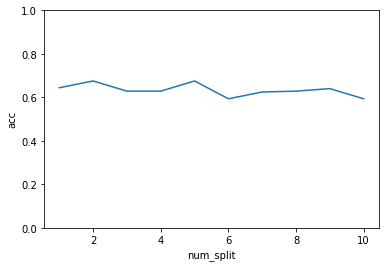

In [8]:
plt.ylim([0,1])
plt.xlabel('num_split')
plt.ylabel('acc')
plt.plot(range(1,11), allAcc)

In [9]:
# normal = False meanAcc = 0.581
# normal = True meanAcc = 0.5811